# Lyapunov Functions and Region of Attraction (ROA) Analysis

## Overview
This notebook presents a comparative analysis of different Lyapunov functions for a nonlinear dynamical system. In particular, we investigate and visualize:

- A **Linear Quadratic Regulator (LQR)** Lyapunov function
- A **Learned Control Lyapunov Function (CLF)** obtained via symbolic regression

The focus is on understanding the stability properties, and implied **Region of Attraction (ROA)** of each Lyapunov candidate.

---

## Objectives
The main objectives of this notebook are:

- To visualize regions where stability conditions are satisfied
- To overlay ROA estimates obtained

---

## Lyapunov Functions Considered

### 1. LQR Lyapunov Function

---

### 2. Learned Control Lyapunov Function (CLF)

---

## Region of Attraction (ROA)
The ROA is approximated by identifying the largest sublevel set of the Lyapunov function fully contained within a verified safe region.


In [1]:
import os
import sys

# Absolute path to project root (../../ from run.py)
project_root = os.path.abspath(
    os.path.join("../../")
)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Make sure Ray subprocesses also see this
os.environ["PYTHONPATH"] = project_root + ":" + os.environ.get("PYTHONPATH", "")

In [2]:
import numpy as np
from scipy.linalg import solve_continuous_are
from numpy.linalg import inv
import control
from sympy import symbols, lambdify, diff, Matrix, sin, cos, tanh, exp, log, sqrt, simplify, Piecewise, simplify

Computing LQR controller and Lyapunov function

In [3]:
#Constants

# Define the system matrices
A = np.array([[0, -1],
              [1, -1]])  # System matrix

B = np.array([[0],           # Input matrix (2x1)
              [-1]])        # Correct input matrix

# Define the LQR weight matrices
Q = np.array([[1, 0],
              [0, 1]])  # State cost

R = np.array([[1]])  # Control cost matrix (1x1) for single input system

# Define symbolic variables
x1, x2 = symbols('x1 x2')

# Define x(x) as a vector
def x(x1, x2):
    return Matrix([x1, x2])

### Approach 2: Using control.lqr ###
# Compute the LQR gain directly
K_control, P_control, eigs = control.lqr(A, B, Q, R)

x = x(x1, x2)

V_LQR = x.T * P_control * x
V_LQR = simplify(V_LQR[0])

u_func_LQR = -K_control * x
u_func_LQR = simplify(u_func_LQR[0])

In [4]:
print("V_LQR is: ", V_LQR)
print("u_func_LQR is: ", u_func_LQR)

V_LQR is:  1.37841423000545*x1**2 - 0.828427124746193*x1*x2 + 0.68179283050743*x2**2
u_func_LQR is:  -0.414213562373096*x1 + 0.68179283050743*x2


Lie-derivative calculation for LQR and Exact Value Function (EVF) and CLF

In [5]:
from src.SymVVdot_Calculations import compute_v_and_v_dotSR
from src.VVdot_Calculations import compute_v_and_v_dot

In [6]:
from src.Functions import Dataset
# Define the numerical grid (Domain)
# 1. Generate initial ranges
x1_raw = np.linspace(-2, 2, 200)
x2_raw = np.linspace(-2, 2, 200)

# 2. Exclude/Clip the specific values from the axes
# This removes any individual coordinate that satisfies your logic
x1_vals = x1_raw[~(np.abs(x1_raw**2 - 1) < 0.02)]
x2_vals = x2_raw[~(x2_raw**2 < 0.02)]
x_vals = [x1_vals, x2_vals]

# 3. Create meshgrid from the filtered axes
X1, X2 = np.meshgrid(x1_vals, x2_vals, indexing="ij")
train_data = Dataset("true_data", [x1_vals, x2_vals], None)
train_data.mesh=[X1, X2]

In [7]:
from SystemDynamics import f, G, Q, R
x1, x2 = symbols('x1 x2')
TRQlim = None # 100
#V_LQR = 
#u_func_LQR = 
_, _, V_dot_LQR, _, _, _, _, _, _ = compute_v_and_v_dot(V_LQR, x_vals, train_data, [1,1], f, G, Q, R, TRQlim, u_func_LQR)


V_CLF = (x1**2 + x2**2)*(3.1980545*sin(x1**2 + x2**2) + 6.72852955974179)
_, _, V_dot_CLF, _, _, _, _, _, _ = compute_v_and_v_dot(V_CLF, x_vals, train_data, [1,1], f, G, Q, R, TRQlim, None)

In [8]:
import numpy as np
from numpy import *
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'png'

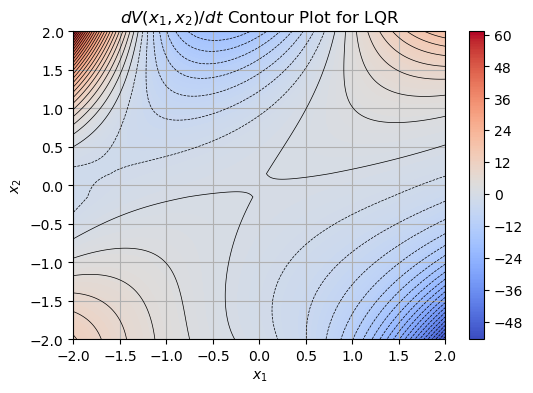

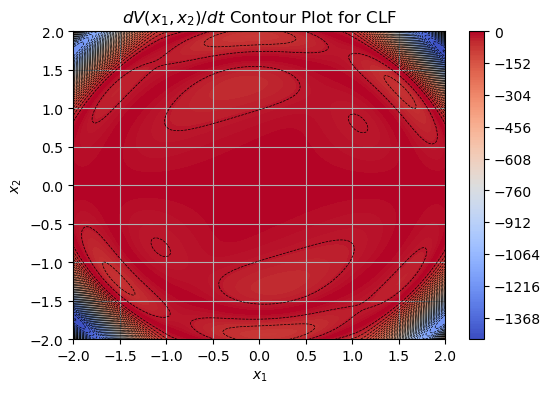

In [9]:
directory = "../Results/ReversedVanDerPol"

from src.plots import (
plot_contour, Plot3D,
Plotflow, Plot3D_V_less_than_zero,
levelset,)

plot_contour(
    X1, X2, V_dot_LQR,
    r"$d V(x_1, x_2) / dt$ Contour Plot for LQR",
    "VdotLimitedLQR.png",
    directory,
    show=True,
)
# plot_contour(
#     X1, X2, V_dot_FLF,
#     r"$d V(x_1, x_2) / dt$ Contour Plot for FLF",
#     "VdotLimitedFLF.png",
#     directory,
#     show=True,
# )
plot_contour(
    X1, X2, V_dot_CLF,
    r"$d V(x_1, x_2) / dt$ Contour Plot for CLF",
    "VdotLimitedCLF.png",
    directory,
    show=True,
)

In [10]:
def Plot3D(X, Y, V, r):
    # Plot Lyapunov functions  
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,V, rstride=5, cstride=5, alpha=0.5, cmap=cm.coolwarm)
    ax.contour(X,Y,V,10, zdir='z', offset=0, cmap=cm.coolwarm)
    
    # Plot Valid region computed by dReal
    theta = np.linspace(0,2*np.pi,50)
    xc = r*cos(theta)
    yc = r*sin(theta)
    ax.plot(xc[:],yc[:],'r',linestyle='--', linewidth=2 ,label='Valid region')
    plt.legend(loc='upper right')
    return ax

def Plotflow(Xd, Yd, t):
    # Plot phase plane 
    DX, DY = f([Xd, Yd],t)
    plt.streamplot(Xd,Yd,DX,DY, color=('gray'), linewidth=0.5,
                  density=0.8, arrowstyle='-|>', arrowsize=1)

In [11]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def Plot3D_V_less_than_zero(X, Y, V, r):
    # Mask out regions where V >= 0
    V_masked = np.where(V < 0, V, np.nan)
    
    # Plot Lyapunov functions
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, V_masked, rstride=5, cstride=5, alpha=0.5, cmap=cm.coolwarm)
    ax.contour(X, Y, V_masked, 10, zdir='z', offset=0, cmap=cm.coolwarm)
    
    # Plot Valid region computed by dReal
    theta = np.linspace(0, 2 * np.pi, 50)
    xc = r * np.cos(theta)
    yc = r * np.sin(theta)
    ax.plot(xc[:], yc[:], 'r', linestyle='--', linewidth=2, label='Valid region')
    plt.legend(loc='upper right')
    return ax


In [12]:
def levelset(x1,x2,V,r):
    N_level = 1000
    cs = plt.contour(x1,x2,V,N_level)
    for i in range(len(cs.levels)-2):
        elements = cs.allsegs[i+1][0]
        elements_sq = np.sum(elements**2,axis = 1)
        if r**2 - np.max(elements_sq) < 1e-6:
            c = cs.levels[i]
            break
    return c

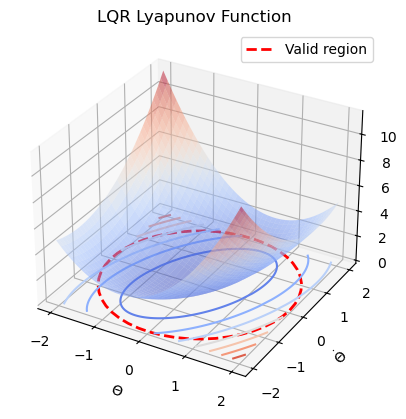

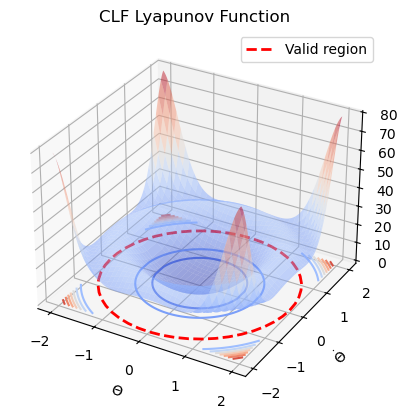

In [13]:
import warnings

rr = 2

# X = np.linspace(-rr, rr, 200) 
# Y = np.linspace(-rr, rr, 200)
# X1, X2 = np.meshgrid(X,Y)

warnings.filterwarnings("ignore")

# V_FLFnum = lambdify((x1, x2), V_FLF, modules='numpy')
# V_FLFnum = V_FLFnum(X1, X2)

V_LQRnum = lambdify((x1, x2), V_LQR, modules='numpy')
V_LQRnum = V_LQRnum(X1, X2)

V_CLFnum = lambdify((x1, x2), V_CLF, modules='numpy')
V_CLFnum = V_CLFnum(X1, X2)

ax = Plot3D(X1,X2,V_LQRnum,rr)
ax.set_xlabel(r'$\Theta$')
ax.set_ylabel(r'$\dot{\Theta}$')
ax.set_zlabel('V')
plt.title('LQR Lyapunov Function')
save_path = os.path.join(directory, "LQRLF.png")
plt.savefig(save_path, dpi=500, bbox_inches='tight')
plt.show()

# ax = Plot3D(X1,X2,V_FLFnum,rr)
# ax.set_xlabel(r'$\Theta$')
# ax.set_ylabel(r'$\dot{\Theta}$')
# ax.set_zlabel('V')
# plt.title('FLF Lyapunov Function')
# save_path = os.path.join(directory, "FLFLF.png")
# plt.savefig(save_path, dpi=500, bbox_inches='tight')
# plt.show()

ax = Plot3D(X1,X2,V_CLFnum,rr)
ax.set_xlabel(r'$\Theta$')
ax.set_ylabel(r'$\dot{\Theta}$')
ax.set_zlabel('V')
plt.title('CLF Lyapunov Function')
save_path = os.path.join(directory, "CLFLF.png")
plt.savefig(save_path, dpi=500, bbox_inches='tight')
plt.show()

In [14]:
# set some font sizes!
xylabel_font_size = 22
axis_font_size = 20
legend_font_size = 20

linewidth = 4

dpi = 300

In [15]:
import numpy as np
import builtins

def boundary_mask_from_D(D_mask, periodic_x1=False):
    D = D_mask.astype(bool)

    up    = np.roll(D, -1, axis=0)
    down  = np.roll(D,  1, axis=0)
    left  = np.roll(D,  1, axis=1)
    right = np.roll(D, -1, axis=1)

    if not periodic_x1:
        left[:,  0] = False
        right[:, -1] = False

    up[-1, :] = False
    down[0, :] = False

    interior = D & up & down & left & right
    return D & (~interior)

def find_max_c_closed_in_D(
    V, V_dot, D_mask,
    c_min=0.0, c_max=20.0, step=0.001,
    vdot_tol=0.0,
    exclude_origin=True, V_origin_tol=1e-12,
    boundary_margin=1e-6,
    periodic_x1=False
):
    bmask = boundary_mask_from_D(D_mask, periodic_x1=periodic_x1)
    if not np.any(bmask):
        raise ValueError("Boundary mask is empty; check D_mask/grid.")

    c_boundary = float(np.min(V[bmask]) - boundary_margin)
    c_hi = builtins.min(float(c_max), c_boundary)

    if c_hi <= c_min:
        return float(c_min)

    c = float(c_min)
    last_ok = float(c_min)

    while c <= c_hi + 1e-15:
        in_Omega = (V < c) & D_mask
        if exclude_origin:
            in_Omega = in_Omega & (V > V_origin_tol)

        if np.any(in_Omega & (V_dot >= -vdot_tol)):
            return last_ok

        last_ok = c
        c += step

    return last_ok


In [16]:
D_mask = (np.abs(X1) <= 2) & (np.abs(X2) <= 2)

max_cLQR = find_max_c_closed_in_D(V_LQRnum, V_dot_LQR, D_mask, c_min=1e-2, c_max=0.1, step=1e-5,
                               vdot_tol=1e-8, periodic_x1=True)
print(f"Maximum c for LQR: {max_cLQR}")

# max_cFLF = find_max_c_closed_in_D(V_FLFnum, V_dot_FLF, D_mask, c_max=20, step=1e-6,
#                                vdot_tol=1e-8, periodic_x1=True)
# print(f"Maximum c for LQR: {max_cFLF}")

max_cCLF = find_max_c_closed_in_D(V_CLFnum, V_dot_CLF, D_mask, c_max=20, step=1e-3,
                               vdot_tol=1e-8, periodic_x1=True)
print(f"Maximum c for CLF: {max_cCLF}")

Maximum c for LQR: 0.013529999999999856
Maximum c for CLF: 16.196999999996812


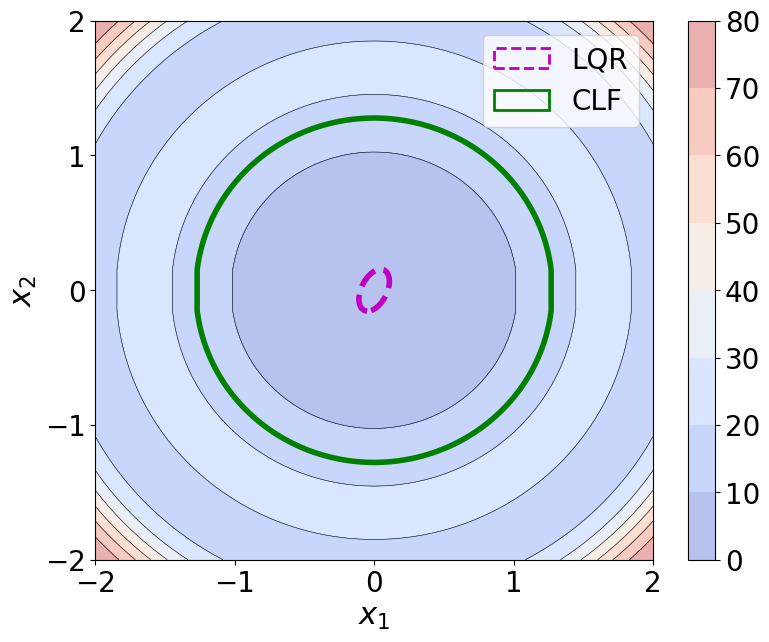

In [17]:
# ax = plt.gca()
fig, ax = plt.subplots(figsize=(9, 7))

# Vaild Region
# C = plt.Circle((0, 0),4, color='k', linewidth=linewidth, fill=False)
# ax.add_artist(C)

# plot direction field
xd = np.linspace(-2, 2, 200) 
yd = np.linspace(-2, 2, 200)
Xd, Yd = np.meshgrid(xd,yd)
V_LQRnum = lambdify((x1, x2), V_LQR, modules='numpy')
V_LQRnum = V_LQRnum(Xd, Yd)
ax.contour(Xd,Yd,V_LQRnum-max_cLQR,0,linewidths=linewidth, colors='m',linestyles='--')
# ax.contour(X,Y,V_FLFnum-max_cFLF,0,linewidths=linewidth, colors='r')
ax.contour(X1,X2,V_CLFnum-max_cCLF,0,linewidths=linewidth, colors='g')


ax.contour(X1,X2,V_CLFnum,8,linewidths=0.4, colors='k')
c1 = ax.contourf(X1,X2,V_CLFnum,8,alpha=0.4,cmap=cm.coolwarm)
# plt.colorbar(c1)
cb = plt.colorbar(c1)
cb.ax.tick_params(labelsize=axis_font_size)


# plt.title('Region of Attraction')
# plt.legend([plt.Rectangle((0,0),1,2,color='k',fill=False,linewidth = 2),plt.Rectangle((0,0),1,2,color='m',fill=False,linewidth = 2,linestyle='--'),plt.Rectangle((0,0),1,2,color='g',fill=False,linewidth = 2),C]\
#            ,['FLF','LQR', 'CLF', 'Valid Region'],loc='upper right')

plt.legend(
    [
        # plt.Rectangle((0, 0), 1, 2, color='r', fill=False, linewidth=2),
        plt.Rectangle((0, 0), 1, 2, color='m', fill=False, linewidth=2, linestyle='--'),
        plt.Rectangle((0, 0), 1, 2, color='g', fill=False, linewidth=2),
        # C
    ],
    [
        # 'FLF',
        'LQR',
        'CLF',
        # 'Valid'
    ],
    loc='upper right',
    fontsize=legend_font_size
)

plt.xlabel(r"$x_1$", fontsize=xylabel_font_size)
plt.ylabel(r"$x_2$", fontsize=xylabel_font_size)
ax.tick_params(axis='both', labelsize=axis_font_size)

ticks = [-2, -1, 0, 1, 2]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# ax.set_aspect("equal", adjustable="box") 

save_path = os.path.join(directory, "roaLimited.png")
plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
plt.show()